In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def regime_breakout(df, _h, _l, window):
    hl = np.where(df[_h] == df[_h].rolling(window).max(), 1,
                  np.where(df[_l] == df[_l].rolling(window).min(), -1, np.nan))
    roll_hl = pd.Series(index=df.index, data=hl).fillna(method='ffill')
    return roll_hl


def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df, _h, _l, window=slow)
    _fast = regime_breakout(df, _h, _l, window=fast)
    turtle = pd.Series(index=df.index,
                       data=np.where(_slow == 1, np.where(_fast == 1, 1, 0),
                                     np.where(_slow == -1, np.where(_fast == -1, -1, 0), 0)))
    return turtle

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': '9984.T Daily P&L & Cumulative P&L'}, xlabel='Date'>

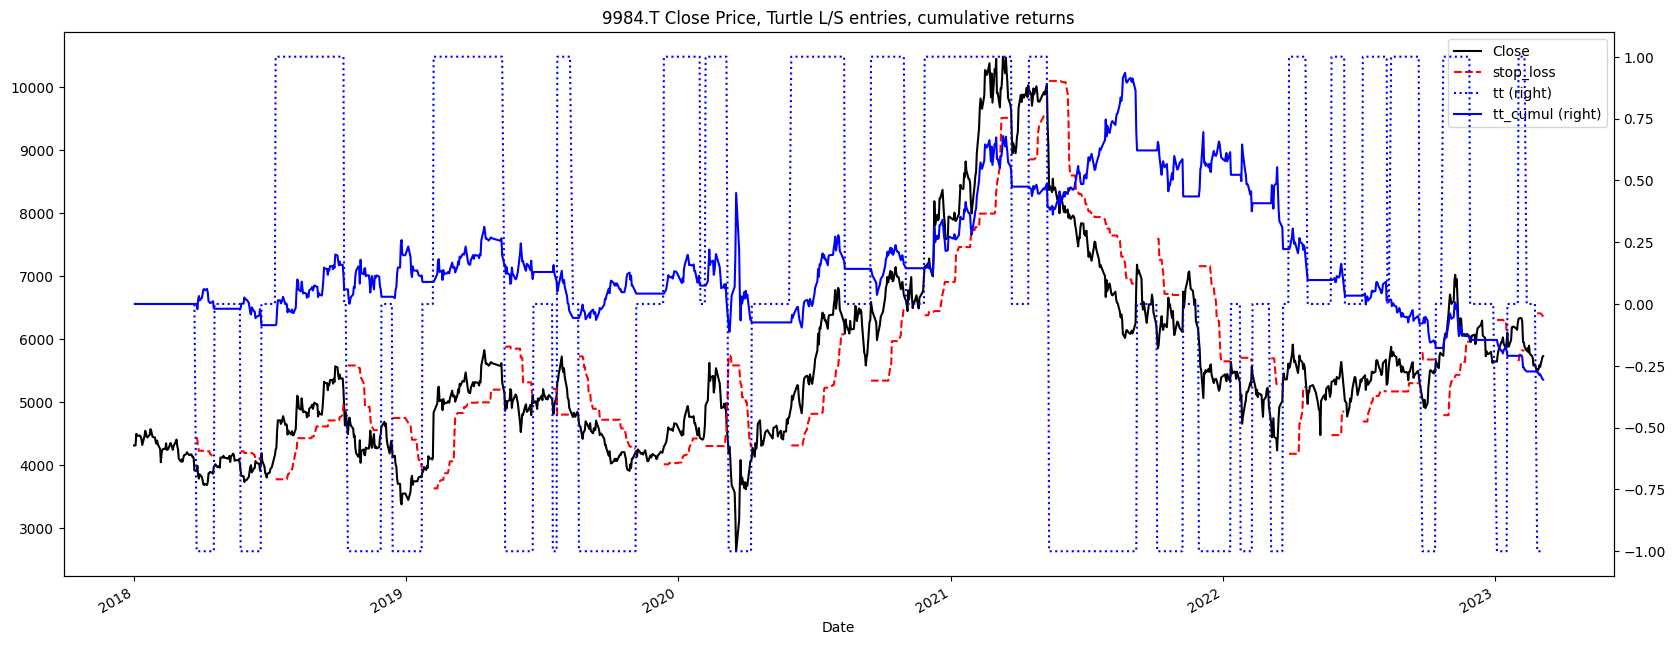

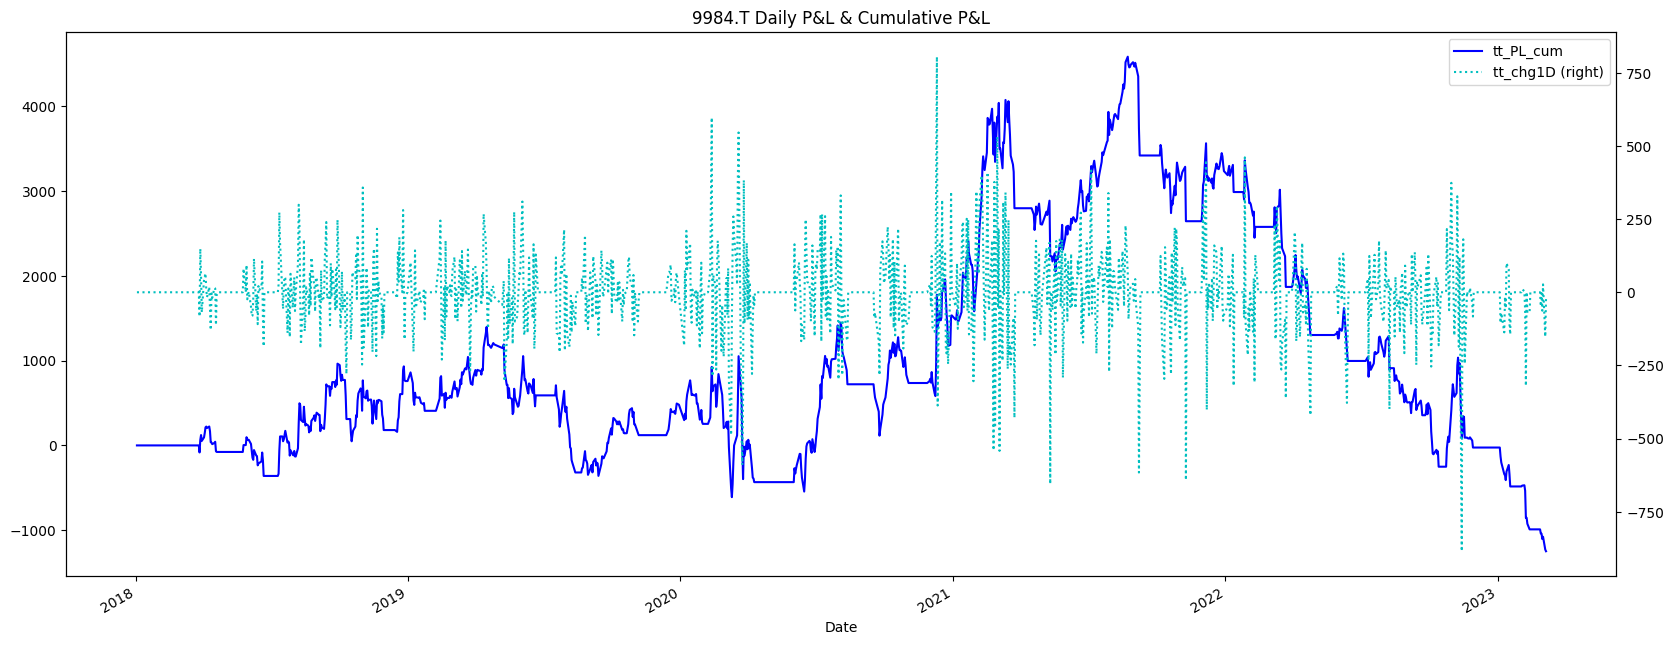

In [6]:
ticker = '9984.T'  # Softbank
start = '2017-12-31'
end = None
df = round(yf.download(tickers=ticker, start=start, end=end,
                       interval="1d", group_by='column', auto_adjust=True,
                       prepost=True, threads=True, proxy=None), 0)
slow = 50
fast = 20
df['tt'] = turtle_trader(df, _h='High', _l='Low', slow=slow, fast=fast)
df['stop_loss'] = np.where(df['tt'] == 1, df['Low'].rolling(fast).min(),
                           np.where(df['tt'] == -1, df['High'].rolling(fast).max(), np.nan))

df['tt_chg1D'] = df['Close'].diff() * df['tt'].shift()
df['tt_PL_cum'] = df['tt_chg1D'].cumsum()

df['tt_returns'] = df['Close'].pct_change() * df['tt'].shift()
tt_log_returns = np.log(df['Close'] / df['Close'].shift()) * df['tt'].shift()
df['tt_cumul'] = tt_log_returns.cumsum().apply(np.exp) - 1

df[['Close', 'stop_loss', 'tt', 'tt_cumul']].plot(secondary_y=['tt', 'tt_cumul'],
                                                  figsize=(20, 8), style=['k', 'r--', 'b:', 'b'],
                                                  title=str(
                                                      ticker) + ' Close Price, Turtle L/S entries, cumulative returns')

df[['tt_PL_cum', 'tt_chg1D']].plot(secondary_y=['tt_chg1D'],
                                   figsize=(20, 8), style=['b', 'c:'],
                                   title=str(ticker) + ' Daily P&L & Cumulative P&L')

<Axes: title={'center': '9984.T cumulative returns, Sharpe ratios: rolling & cumulative'}, xlabel='Date'>

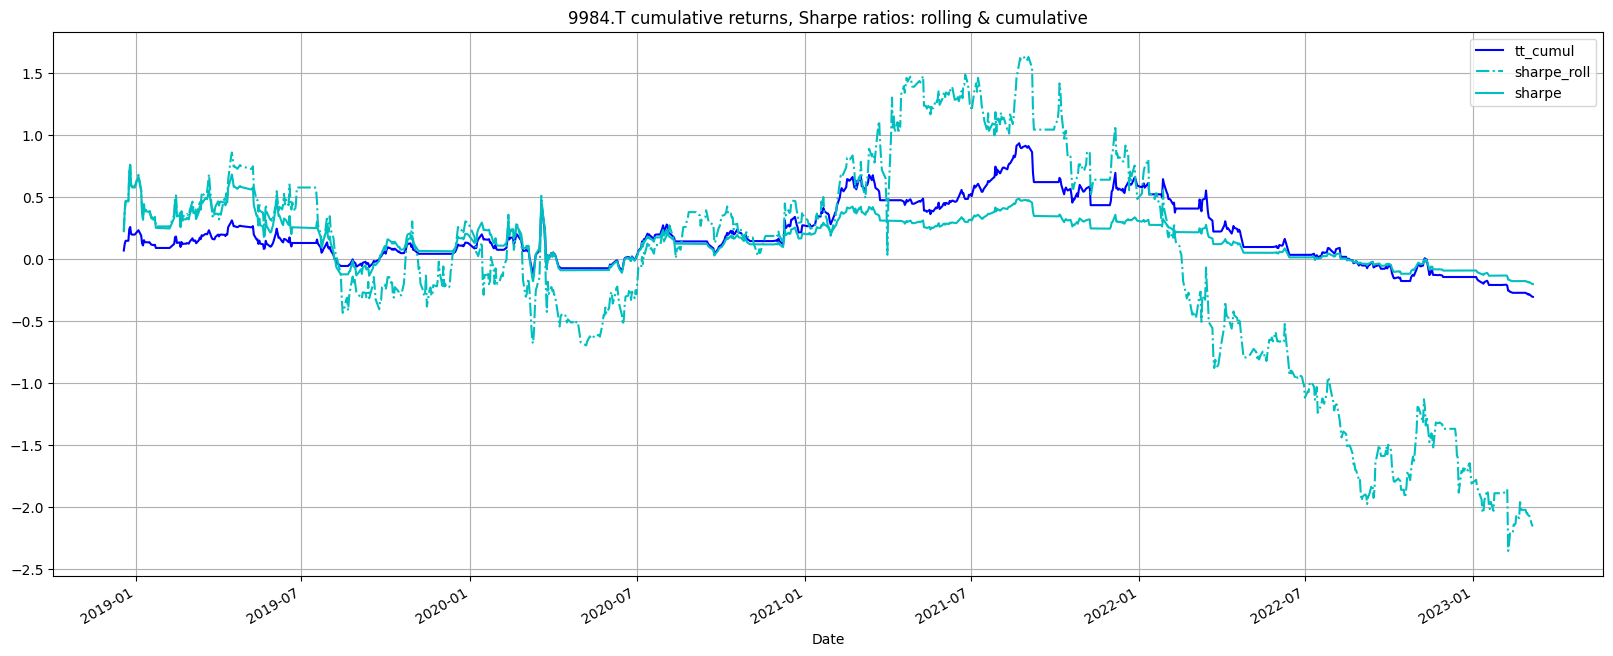

In [7]:
# Risk-free rate
r_f = 0.00001


def rolling_sharpe(returns, r_f, window):
    avg_returns = returns.rolling(window).mean()
    std_returns = returns.rolling(window).std(ddof=0)
    return (avg_returns - r_f) / std_returns


def expanding_sharpe(returns, r_f):
    avg_returns = returns.expanding().mean()
    std_returns = returns.expanding().std(ddof=0)
    return (avg_returns - r_f) / std_returns


window = 252
df['sharpe_roll'] = rolling_sharpe(returns=tt_log_returns, r_f=r_f, window=window) * 252 ** 0.5

df['sharpe'] = expanding_sharpe(returns=tt_log_returns, r_f=r_f) * 252 ** 0.5

df[window:][['tt_cumul', 'sharpe_roll', 'sharpe']].plot(figsize=(20, 8), style=['b', 'c-.', 'c'], grid=True,
                                                        title=str(
                                                            ticker) + ' cumulative returns, Sharpe ratios: rolling & cumulative')

<Axes: title={'center': '9984.T cumulative returns & Grit Ratios: rolling & cumulative 252 days'}, xlabel='Date'>

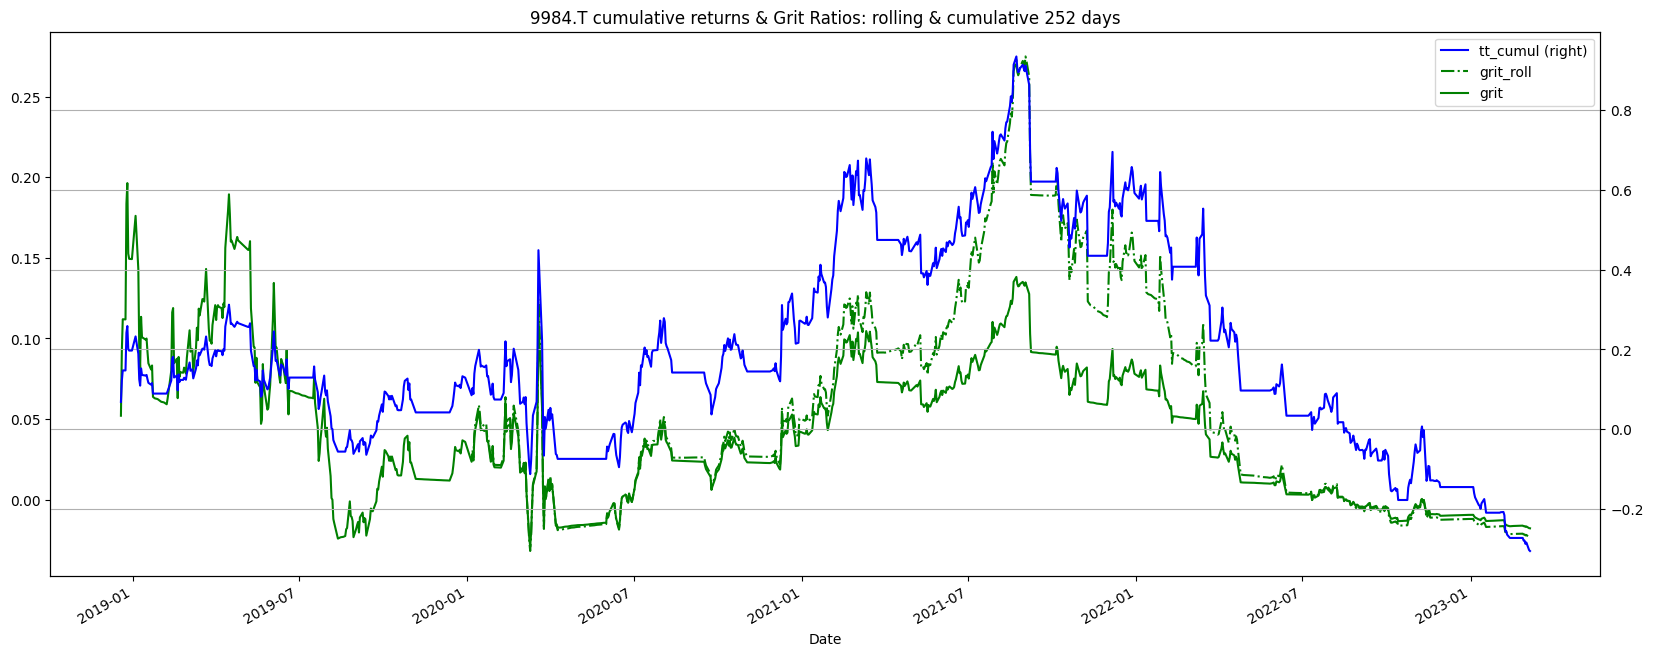

In [8]:
def rolling_grit(cumul_returns, window):
    tt_rolling_peak = cumul_returns.rolling(window).max()
    drawdown_squared = (cumul_returns - tt_rolling_peak) ** 2
    ulcer = drawdown_squared.rolling(window).sum() ** 0.5
    return cumul_returns / ulcer


def expanding_grit(cumul_returns):
    tt_peak = cumul_returns.expanding().max()
    drawdown_squared = (cumul_returns - tt_peak) ** 2
    ulcer = drawdown_squared.expanding().sum() ** 0.5
    return cumul_returns / ulcer


window = 252
df['grit_roll'] = rolling_grit(cumul_returns=df['tt_cumul'], window=window)
df['grit'] = expanding_grit(cumul_returns=df['tt_cumul'])
df[window:][['tt_cumul', 'grit_roll', 'grit']].plot(figsize=(20, 8),
                                                    secondary_y='tt_cumul', style=['b', 'g-.', 'g'], grid=True,
                                                    title=str(
                                                        ticker) + ' cumulative returns & Grit Ratios: rolling & cumulative ' + str(
                                                        window) + ' days')

In [9]:
def rolling_profits(returns, window):
    profit_roll = returns.copy()
    profit_roll[profit_roll < 0] = 0
    profit_roll_sum = profit_roll.rolling(window).sum().fillna(method='ffill')
    return profit_roll_sum


def rolling_losses(returns, window):
    loss_roll = returns.copy()
    loss_roll[loss_roll > 0] = 0
    loss_roll_sum = loss_roll.rolling(window).sum().fillna(method='ffill')
    return loss_roll_sum


def expanding_profits(returns):
    profit_roll = returns.copy()
    profit_roll[profit_roll < 0] = 0
    profit_roll_sum = profit_roll.expanding().sum().fillna(method='ffill')
    return profit_roll_sum


def expanding_losses(returns):
    loss_roll = returns.copy()
    loss_roll[loss_roll > 0] = 0
    loss_roll_sum = loss_roll.expanding().sum().fillna(method='ffill')
    return loss_roll_sum


def profit_ratio(profits, losses):
    pr = profits.fillna(method='ffill') / abs(losses.fillna(method='ffill'))
    return pr


def rolling_tail_ratio(cumul_returns, window, percentile, limit):
    left_tail = np.abs(cumul_returns.rolling(window).quantile(percentile))
    right_tail = cumul_returns.rolling(window).quantile(1 - percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail, limit), -limit)
    return tail


def expanding_tail_ratio(cumul_returns, percentile, limit):
    left_tail = np.abs(cumul_returns.expanding().quantile(percentile))
    right_tail = cumul_returns.expanding().quantile(1 - percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail, limit), -limit)
    return tail


def common_sense_ratio(pr, tr):
    return pr * tr

<Axes: xlabel='Date'>

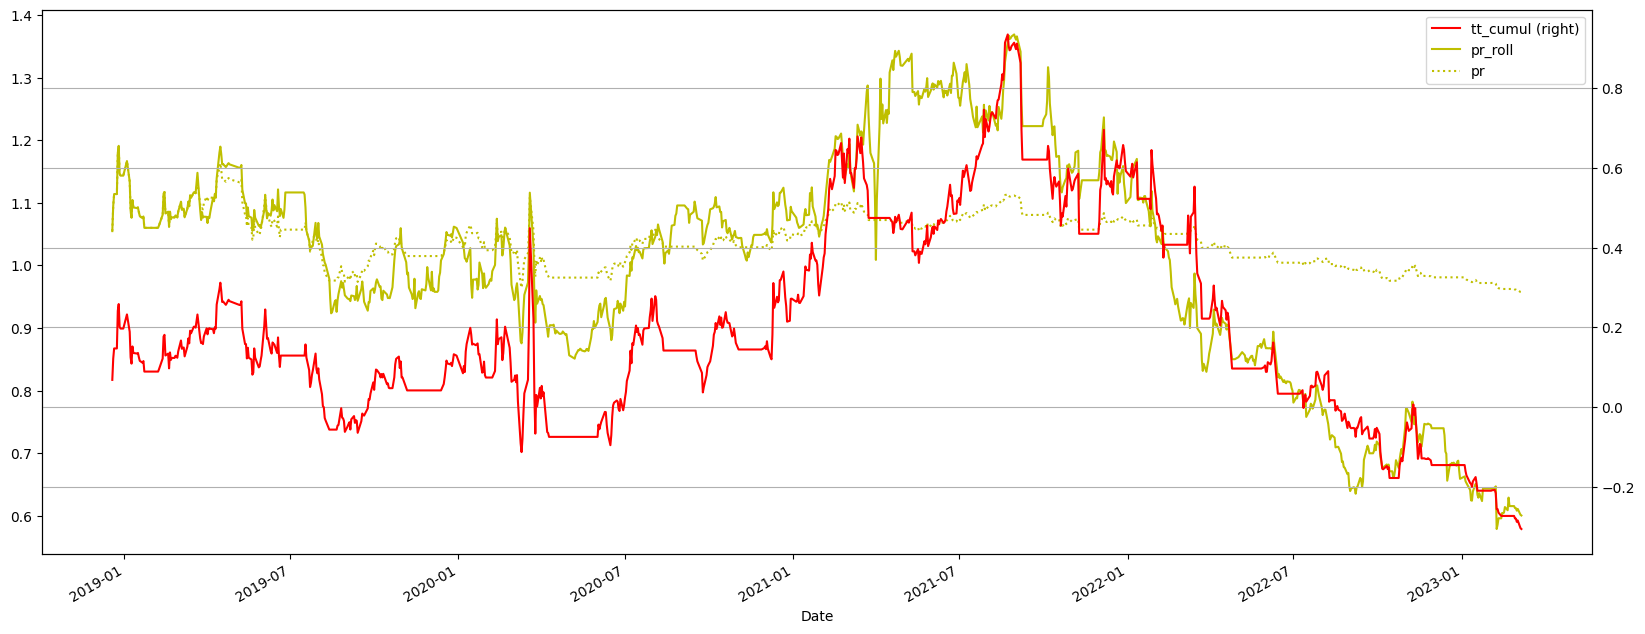

In [10]:
window = 252
df['pr_roll'] = profit_ratio(profits=rolling_profits(returns=tt_log_returns, window=window),
                             losses=rolling_losses(returns=tt_log_returns, window=window))
df['pr'] = profit_ratio(profits=expanding_profits(returns=tt_log_returns),
                        losses=expanding_losses(returns=tt_log_returns))

df[window:][['tt_cumul', 'pr_roll', 'pr']].plot(figsize=(20, 8), secondary_y=['tt_cumul'],
                                                style=['r', 'y', 'y:'], grid=True)

<Axes: title={'center': '9984.T cumulative returns, Common Sense Ratios: cumulative &  rolling 252 days'}, xlabel='Date'>

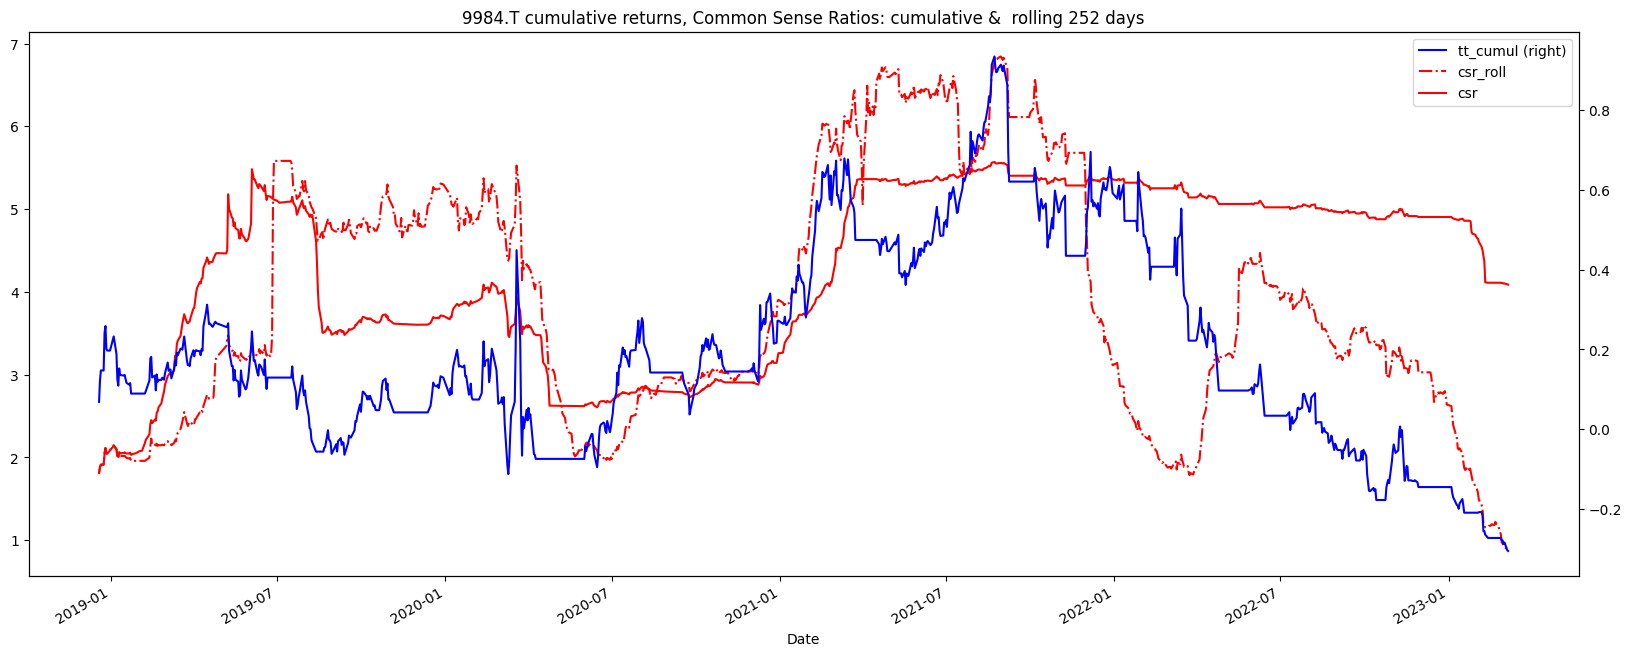

In [11]:
window = 252

df['tr_roll'] = rolling_tail_ratio(cumul_returns=df['tt_cumul'],
                                   window=window, percentile=0.05, limit=5)
df['tr'] = expanding_tail_ratio(cumul_returns=df['tt_cumul'], percentile=0.05, limit=5)

df['csr_roll'] = common_sense_ratio(pr=df['pr_roll'], tr=df['tr_roll'])
df['csr'] = common_sense_ratio(pr=df['pr'], tr=df['tr'])

df[window:][['tt_cumul', 'csr_roll', 'csr']].plot(secondary_y=['tt_cumul'], style=['b', 'r-.', 'r'], figsize=(20, 8),
                                                  title=str(
                                                      ticker) + ' cumulative returns, Common Sense Ratios: cumulative &  rolling ' + str(
                                                      window) + ' days')

<Axes: title={'center': '9984.T Cumulative Returns and SQN: cumulative & rolling252 days'}, xlabel='Date'>

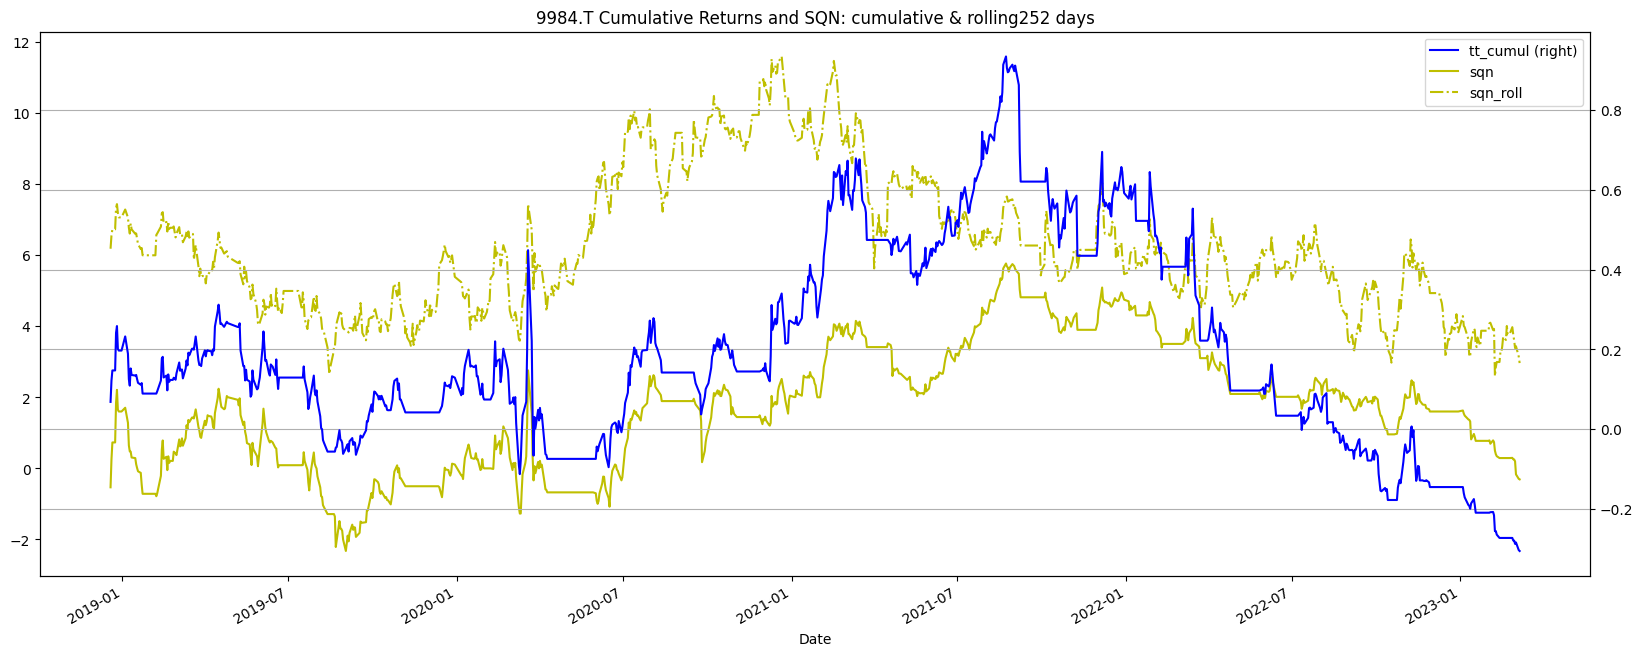

In [12]:
def expectancy(win_rate, avg_win, avg_loss):
    # win% * avg_win% - loss% * abs(avg_loss%)
    return win_rate * avg_win + (1 - win_rate) * avg_loss


def t_stat(signal_count, trading_edge):
    sqn = (signal_count ** 0.5) * trading_edge / trading_edge.std(ddof=0)
    return sqn


# Trade Count
df['trades'] = df.loc[(df['tt'].diff() != 0) & (pd.notnull(df['tt'])), 'tt'].abs().cumsum()
signal_count = df['trades'].fillna(method='ffill')
signal_roll = signal_count.diff(window)

# Rolling t_stat
window = 252
win_roll = tt_log_returns.copy()
win_roll[win_roll < 0] = np.nan
win_rate_roll = win_roll.rolling(window, min_periods=0).count() / window
avg_win_roll = rolling_profits(returns=tt_log_returns, window=window) / window
avg_loss_roll = rolling_losses(returns=tt_log_returns, window=window) / window

edge_roll = expectancy(win_rate=win_rate_roll, avg_win=avg_win_roll, avg_loss=avg_loss_roll)
df['sqn_roll'] = t_stat(signal_count=signal_roll, trading_edge=edge_roll)

# Cumulative t-stat
tt_win_count = tt_log_returns[tt_log_returns > 0].expanding().count().fillna(method='ffill')
tt_count = tt_log_returns[tt_log_returns != 0].expanding().count().fillna(method='ffill')

win_rate = (tt_win_count / tt_count).fillna(method='ffill')
avg_win = expanding_profits(returns=tt_log_returns) / tt_count
avg_loss = expanding_losses(returns=tt_log_returns) / tt_count
trading_edge = expectancy(win_rate, avg_win, avg_loss).fillna(method='ffill')
df['sqn'] = t_stat(signal_count, trading_edge)

df[window:][['tt_cumul', 'sqn', 'sqn_roll']].plot(figsize=(20, 8),
                                                  secondary_y=['tt_cumul'], grid=True, style=['b', 'y', 'y-.'],
                                                  title=str(
                                                      ticker) + ' Cumulative Returns and SQN: cumulative & rolling' + str(
                                                      window) + ' days')

<Axes: title={'center': '9984.T Cumulative Returns and Robustness Score: cumulative & rolling 252 days'}, xlabel='Date'>

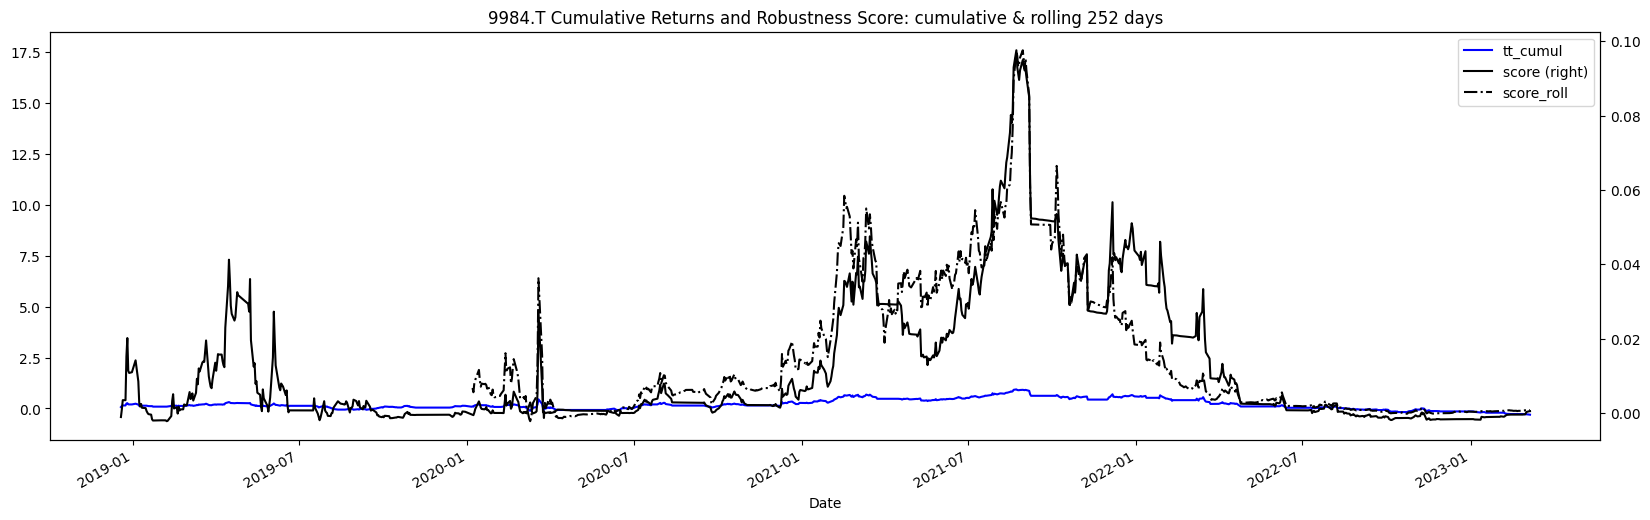

In [13]:
def robustness_score(grit, csr, sqn):
    start_date = max(grit[pd.notnull(grit)].index[0],
                     csr[pd.notnull(csr)].index[0],
                     sqn[pd.notnull(sqn)].index[0])
    score = grit * csr * sqn / (grit[start_date] * csr[start_date] * sqn[start_date])
    return score


df['score_roll'] = robustness_score(grit=df['grit_roll'], csr=df['csr_roll'], sqn=df['sqn_roll'])
df['score'] = robustness_score(grit=df['grit'], csr=df['csr'], sqn=df['sqn'])
df[window:][['tt_cumul', 'score', 'score_roll']].plot(
    secondary_y=['score'], figsize=(20, 6), style=['b', 'k', 'k-.'],
    title=str(ticker) + ' Cumulative Returns and Robustness Score: cumulative & rolling ' + str(window) + ' days')